# Train and Visualize a PC on the Moons Dataset

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

Set the random seeds.

In [2]:
random.seed(42)
np.random.seed(42)

Generate the Dataset

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

data = make_moons(n_samples=3000, noise=0.1, random_state=0)

X, y = data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Instantiate the PC

In [4]:
import cirkit.templates.region_graph as rg

region_graph = rg.algorithms.FullyFactorized(num_vars=2)

In [5]:
assert region_graph.is_smooth and region_graph.is_decomposable and region_graph.is_structured_decomposable and region_graph.is_omni_compatible

In [6]:
from cirkit.utils.scope import Scope
from cirkit.symbolic.parameters import Parameter, TensorParameter, SoftmaxParameter
from cirkit.symbolic.layers import GaussianLayer, DenseLayer, HadamardLayer
from cirkit.symbolic.initializers import NormalInitializer

In [7]:
def gaussian_layer_factory(
    scope: Scope,
    num_units: int,
    num_channels: int
) -> GaussianLayer:
    return GaussianLayer(scope, num_units, num_channels)

def hadamard_layer_factory(
    scope: Scope, num_input_units: int, arity: int
) -> HadamardLayer:
    return HadamardLayer(scope, num_input_units, arity)

def dense_layer_factory(
    scope: Scope,
    num_input_units: int,
    num_output_units: int
) -> DenseLayer:
    return DenseLayer(
        scope, num_input_units, num_output_units,
        weight_factory=lambda shape: Parameter.from_unary(
            SoftmaxParameter(shape),
            TensorParameter(*shape, initializer=NormalInitializer(0.0, 1e-1)),
        )
    )

In [8]:
from cirkit.symbolic.circuit import Circuit

In [9]:
symbolic_circuit = Circuit.from_region_graph(
    region_graph,
    num_input_units=32,
    num_sum_units=32,
    input_factory=gaussian_layer_factory,
    sum_factory=dense_layer_factory,
    prod_factory=hadamard_layer_factory
)

In [10]:
import torch
device = torch.device('cuda:1')  # The device to use
torch.manual_seed(42)
if 'cuda' in device.type:
    torch.cuda.manual_seed(42)

In [11]:
from cirkit.pipeline import PipelineContext

In [12]:
ctx = PipelineContext(
    backend='torch',   # Choose the torch compilation backend
    fold=True,         # Fold the circuit, this is a backend-specific compilation flag
    semiring='lse-sum' # Use the (R, +, *) semiring, where + is the log-sum-exp and * is the sum
)
circuit = ctx.compile(symbolic_circuit).to(device)

In [13]:
print(circuit)

TorchCircuit(
  (_nodes): ModuleList(
    (0): TorchGaussianLayer(
      (mean): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
        )
      )
      (stddev): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchScaledSigmoidParameter()
        )
      )
    )
    (1): TorchDenseLayer(
      (weight): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchSoftmaxParameter()
        )
      )
    )
    (2): TorchHadamardLayer()
    (3): TorchDenseLayer(
      (weight): TorchParameter(
        (_nodes): ModuleList(
          (0): TorchTensorParameter()
          (1): TorchSoftmaxParameter()
        )
      )
    )
  )
)


prepare the dataset for pytorch

In [14]:
from torch import optim
from torch.utils.data import DataLoader
train_dataloader = DataLoader(X_train, shuffle=True, batch_size=64)
test_dataloader = DataLoader(X_test, shuffle=False, batch_size=256)
optimizer = optim.Adam(circuit.parameters(), lr=0.05)

setting up the data for the plots

In [15]:
x1_bounds = (-1.5,2.5)
x2_bounds = (-1,1.5)
num_samples = 400
x2 = np.linspace(0, 1, num_samples)*(x2_bounds[1] - x2_bounds[0]) + x2_bounds[0]
x1 = np.linspace(0, 1, num_samples)*(x1_bounds[1] - x1_bounds[0]) + x1_bounds[0]
x1v, x2v = np.meshgrid(x1, x2)
X_meshgrid_np = np.stack((x1v,x2v), axis=-1).reshape(-1,2)
X_meshgrid = torch.from_numpy(X_meshgrid_np).float()
X_meshgrid_np.shape

(160000, 2)

In [16]:
X_meshgrid.min(0).values, X_meshgrid.max(0).values

(tensor([-1.5000, -1.0000]), tensor([2.5000, 1.5000]))

In [17]:
from matplotlib.pyplot import xlim, ylim

def print_density(title=None, scatter=False):
    log_probs = circuit(X_meshgrid.to(device).float().unsqueeze(dim=1))
    log_probs = log_probs.reshape(num_samples, num_samples)
    plt.imshow(log_probs.cpu().detach().numpy(), extent=(*x1_bounds, *x2_bounds), origin="lower")
    if title is not None:
        plt.title(title)
    if scatter:
        plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5)
    plt.show()

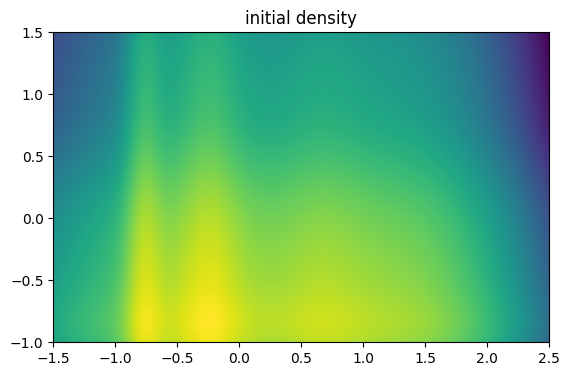

In [18]:
print_density("initial density")

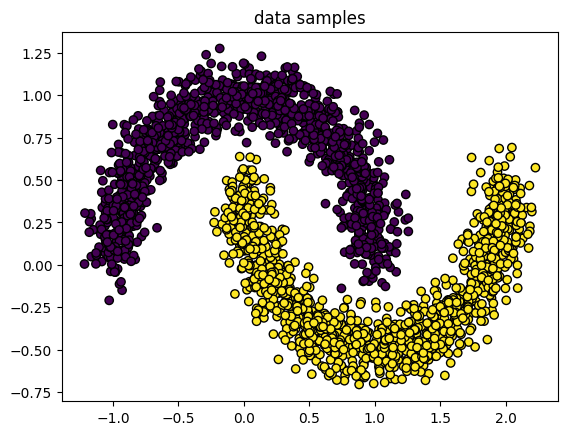

In [19]:
plt.title("data samples")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k")
plt.show()

In [20]:
losses = []

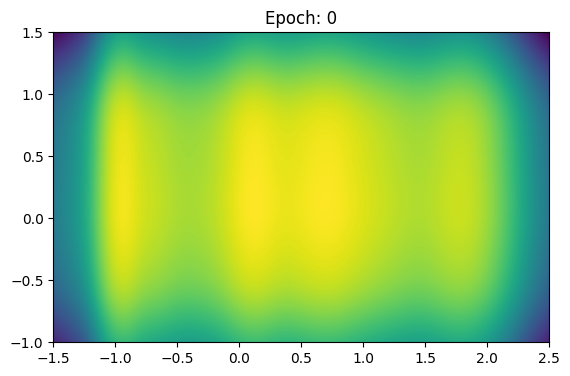

Epoch 0: Average NLL: 2.090
Epoch 5: Average NLL: 1.256
Epoch 10: Average NLL: 1.180
Epoch 15: Average NLL: 1.145
Epoch 20: Average NLL: 1.134
Epoch 25: Average NLL: 1.145
Epoch 30: Average NLL: 1.148
Epoch 35: Average NLL: 1.154
Epoch 40: Average NLL: 1.147
Epoch 45: Average NLL: 1.129
Epoch 50: Average NLL: 1.120
Epoch 55: Average NLL: 1.126
Epoch 60: Average NLL: 1.141
Epoch 65: Average NLL: 1.141
Epoch 70: Average NLL: 1.116
Epoch 75: Average NLL: 1.126
Epoch 80: Average NLL: 1.129
Epoch 85: Average NLL: 1.128
Epoch 90: Average NLL: 1.143
Epoch 95: Average NLL: 1.133


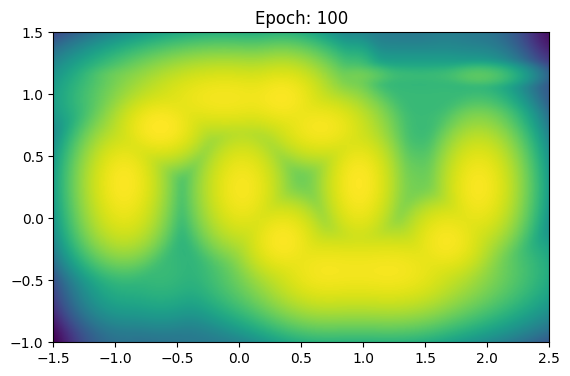

Epoch 100: Average NLL: 1.146
Epoch 105: Average NLL: 1.133
Epoch 110: Average NLL: 1.141
Epoch 115: Average NLL: 1.143
Epoch 120: Average NLL: 1.118
Epoch 125: Average NLL: 1.130
Epoch 130: Average NLL: 1.142
Epoch 135: Average NLL: 1.135
Epoch 140: Average NLL: 1.136
Epoch 145: Average NLL: 1.117
Epoch 150: Average NLL: 1.121
Epoch 155: Average NLL: 1.135
Epoch 160: Average NLL: 1.124
Epoch 165: Average NLL: 1.138
Epoch 170: Average NLL: 1.124
Epoch 175: Average NLL: 1.134
Epoch 180: Average NLL: 1.126
Epoch 185: Average NLL: 1.142
Epoch 190: Average NLL: 1.150
Epoch 195: Average NLL: 1.138


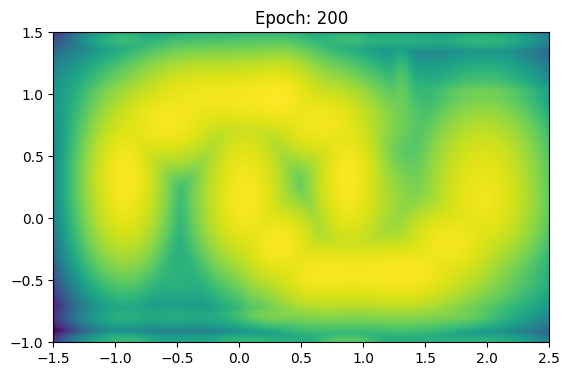

Epoch 200: Average NLL: 1.132
Epoch 205: Average NLL: 1.131
Epoch 210: Average NLL: 1.133
Epoch 215: Average NLL: 1.127
Epoch 220: Average NLL: 1.123
Epoch 225: Average NLL: 1.131
Epoch 230: Average NLL: 1.127
Epoch 235: Average NLL: 1.127
Epoch 240: Average NLL: 1.133
Epoch 245: Average NLL: 1.128
Epoch 250: Average NLL: 1.131
Epoch 255: Average NLL: 1.124
Epoch 260: Average NLL: 1.125
Epoch 265: Average NLL: 1.128
Epoch 270: Average NLL: 1.137
Epoch 275: Average NLL: 1.128
Epoch 280: Average NLL: 1.122
Epoch 285: Average NLL: 1.123
Epoch 290: Average NLL: 1.137
Epoch 295: Average NLL: 1.134


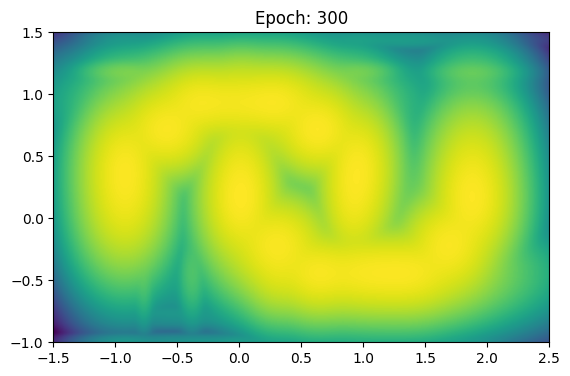

Epoch 300: Average NLL: 1.146
Epoch 305: Average NLL: 1.124
Epoch 310: Average NLL: 1.125
Epoch 315: Average NLL: 1.126
Epoch 320: Average NLL: 1.119
Epoch 325: Average NLL: 1.140
Epoch 330: Average NLL: 1.133
Epoch 335: Average NLL: 1.127
Epoch 340: Average NLL: 1.150
Epoch 345: Average NLL: 1.138
Epoch 350: Average NLL: 1.136
Epoch 355: Average NLL: 1.124
Epoch 360: Average NLL: 1.127
Epoch 365: Average NLL: 1.116
Epoch 370: Average NLL: 1.126
Epoch 375: Average NLL: 1.130
Epoch 380: Average NLL: 1.132
Epoch 385: Average NLL: 1.136
Epoch 390: Average NLL: 1.128
Epoch 395: Average NLL: 1.127


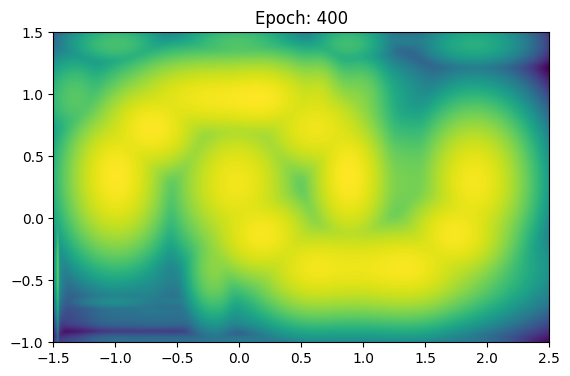

Epoch 400: Average NLL: 1.133
Epoch 405: Average NLL: 1.138
Epoch 410: Average NLL: 1.146
Epoch 415: Average NLL: 1.139
Epoch 420: Average NLL: 1.132
Epoch 425: Average NLL: 1.121
Epoch 430: Average NLL: 1.121
Epoch 435: Average NLL: 1.129
Epoch 440: Average NLL: 1.121
Epoch 445: Average NLL: 1.125
Epoch 450: Average NLL: 1.138
Epoch 455: Average NLL: 1.136
Epoch 460: Average NLL: 1.136
Epoch 465: Average NLL: 1.142
Epoch 470: Average NLL: 1.132
Epoch 475: Average NLL: 1.131
Epoch 480: Average NLL: 1.128
Epoch 485: Average NLL: 1.133
Epoch 490: Average NLL: 1.119
Epoch 495: Average NLL: 1.116


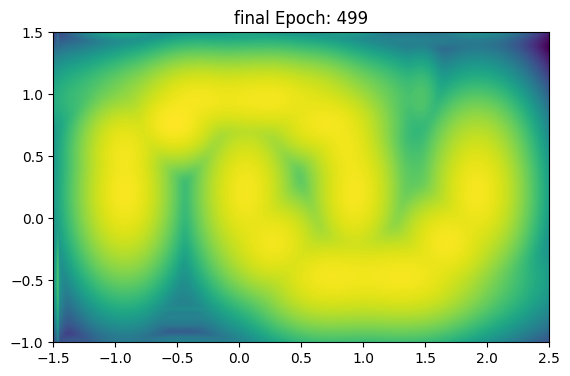

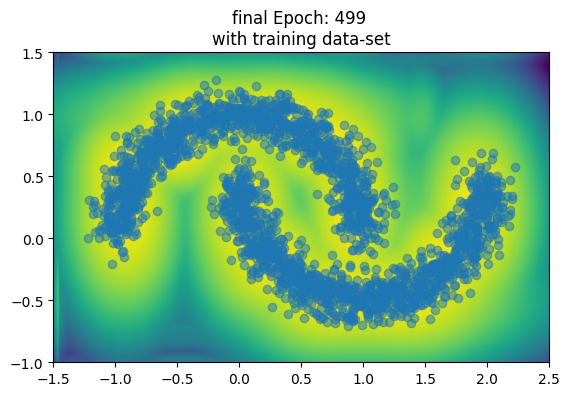

In [21]:
num_epochs = 500
for epoch_idx in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        batch = batch.to(device).float().unsqueeze(dim=1)  # Add a channel dimension
        log_probs = circuit(batch)
        loss = -torch.mean(log_probs)   # The loss is the negative average log-likelihood
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss * len(batch)

    losses.append((running_loss / len(X_train)).cpu().detach().numpy())
    if epoch_idx % (num_epochs // 5) == 0:
        print_density(f"Epoch: {epoch_idx}")
    if epoch_idx % (num_epochs // 100) == 0:
        print(f"Epoch {epoch_idx}: Average NLL: {running_loss / len(X_train):.3f}")
print_density(f"final Epoch: {epoch_idx}", scatter=False)
print_density(f"final Epoch: {epoch_idx} \nwith training data-set", scatter=True)

test hold-out average log-likelihood

In [22]:
test_running_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device).float().unsqueeze(dim=1)  # Add a channel dimension
        log_probs = circuit(batch)
        loss = -torch.mean(log_probs)   # The loss is the negative average log-likelihood
        test_running_loss += loss * len(batch)
train_running_loss = 0.0
with torch.no_grad():
    for batch in train_dataloader:
        batch = batch.to(device).float().unsqueeze(dim=1)  # Add a channel dimension
        log_probs = circuit(batch)
        loss = -torch.mean(log_probs)   # The loss is the negative average log-likelihood
        train_running_loss += loss * len(batch)
print(f"hold-out avg log-like.: {test_running_loss/len(X_test):.2f} vs train: {train_running_loss/len(X_train):.2f}")

hold-out avg log-like.: 1.09 vs train: 1.11


A 3d-plot better visualizes our resulting density

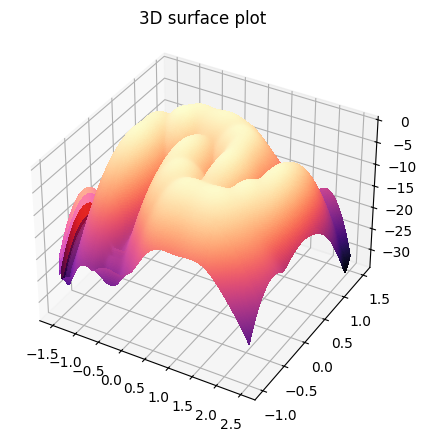

In [23]:
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from matplotlib import colormaps


log_probs = circuit(X_meshgrid.to(device).float().unsqueeze(dim=1)).detach().cpu()
log_probs = log_probs.reshape(num_samples, num_samples).numpy()
nrows, ncols = log_probs.shape

# Set up plot
fig, ax = plt.subplots(figsize=(15,5), subplot_kw=dict(projection='3d'))
ax.set_title("3D surface plot")
ls = LightSource(270, 25)

# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(log_probs, cmap=colormaps["magma"], vert_exag=1.0, blend_mode='soft')
ax.view_init(elev=35.)
surf = ax.plot_surface(x1v, x2v, log_probs, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

our log-likelihood over iterations

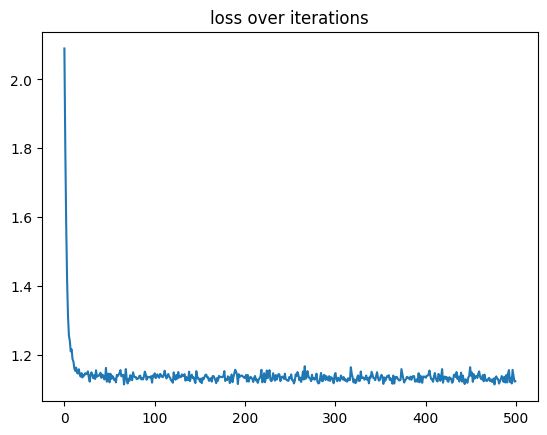

In [24]:
plt.title("loss over iterations")
plt.plot(losses)
plt.show()

our circuit is normalized by construction, which we can verify like this:

In [25]:
from cirkit.pipeline import integrate
with ctx:
    pc_pf = integrate(circuit).to(device)

In [26]:
log_pf = pc_pf()
assert torch.allclose(log_pf, torch.tensor(0.), atol=1e-6)